In [59]:
import pandas as pd
import numpy as np
import ast

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import spacy
from gensim import corpora
from gensim.models.ldamodel import LdaModel

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fannl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [60]:
DATA_FOLDER = "data/"

movies = pd.read_csv(DATA_FOLDER + "v1_movies_cleaned.csv")

for col in movies.columns:
    try:
        movies[col] = movies[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    except:
        pass
    print(col, type(movies[col][0]))

title <class 'str'>
languages <class 'list'>
countries <class 'list'>
genres <class 'list'>
keywords <class 'float'>
release_date <class 'str'>
plot_summary <class 'str'>
year_release_date <class 'numpy.int64'>
cold_war_side <class 'str'>
character_western_bloc_representation <class 'list'>
character_eastern_bloc_representation <class 'list'>
western_bloc_values <class 'list'>
eastern_bloc_values <class 'list'>
theme <class 'list'>


In [61]:
# helpers 
VOC_MAPPING = {
    'anti-': 'anti',
    'anti ': 'anti',
    'anti hero': 'antihero',
    'archetypes': 'archetype',
    'archetype:': 'archetype',
}

# Function to split the row list into character name and character representation
def extract_character_name_and_attributes(row):
    if isinstance(row, list) and len(row) > 0 and row[0] is not None:
        character_name = row[0]
        character_representation = row[1:]
        return pd.Series([character_name, character_representation])
    else:
        return pd.Series([None, None])

# Function to apply the mapping with substring matching
def apply_mapping_with_substrings(string_list, mapping):
    updated = []
    for s in string_list:
        new_s = s
        for key, value in mapping.items():
            if key in s:
                new_s = s.replace(key, value)
        updated.append(new_s.lower())
    return updated

In [62]:
def create_character_df(original_df, character_column, character_side):
    # create the new dataframe
    new_df = original_df[[character_column, 'cold_war_side', 'title', 'year_release_date']]
    new_df = new_df.rename(columns={'cold_war_side': 'movie_side'})
    new_df[['character_name', 'character_representation']] = \
        new_df[character_column].apply(extract_character_name_and_attributes)
    new_df = new_df.drop(columns=[character_column])
    new_df['character_side'] = character_side

    # clean the obtained dataframe
    new_df = new_df.drop_duplicates(subset=['character_name'])
    new_df = new_df[new_df['character_representation'].apply(lambda x: len(x) > 0 if isinstance(x, list) else False)]
    new_df = new_df[new_df['character_name'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0) <= 5]
    new_df['character_representation'] = new_df['character_representation'].apply(
        lambda x: apply_mapping_with_substrings(x, VOC_MAPPING)
    )
    return new_df

In [63]:
character_eastern = create_character_df(movies, 'character_eastern_bloc_representation', 'Eastern')
character_western = create_character_df(movies, 'character_western_bloc_representation', 'Western')

In [64]:
character_eastern.sample(5)

,movie_side,title,year_release_date,character_name,character_representation,character_side
9841,Western,Hair,1979,George Berger,"[counterculture values, rebel leader]",Eastern
2923,Eastern,Belaya kost,1989,Grant Danelian,"[secret agent, resourcefulness, pragmatism, he...",Eastern
28416,Western,The Thirty-Nine Steps,1978,Colonel Scudder,"[bravery, intelligence, mentor]",Eastern
31500,Eastern,White Sun of the Desert,1969,Paul Vereschagin,"[nostalgia, decline, tragic]",Eastern
6947,Western,Double Dragon,1994,Koga Shuko,"[representing corruption, greed, power, villai...",Eastern


In [65]:
character_western.sample(5)

,movie_side,title,year_release_date,character_name,character_representation,character_side
12485,Eastern,"Khotite - verte, khotite - net...",1964,Roman Kurykin,"[a devoted father, values artistic expression ...",Western
4545,Western,Challenge,1984,Ram Mohan Rao,"[business tycoon, capitalist values, antagonist]",Western
22775,Western,Targets,1968,Bobby Thompson,"[violence, chaos, antihero]",Western
20408,Eastern,Scarlet Sails,1961,Assol,"[hope, innocence, heroine]",Western
9150,Western,Genesis II,1973,Dylan Hunt,"[knowledge, idealism, hero]",Western


In [66]:
character_df = pd.concat([character_eastern, character_western], axis=0)
character_df.sample(5)

,movie_side,title,year_release_date,character_name,character_representation,character_side
28647,Western,The Unstoppable Man,1960,Inspector Hazelrigg,"[british authority, practical, supportive, men...",Eastern
10949,Western,I Became a Criminal,1947,freedom and revenge,[archetype anti-hero],Western
31556,None,Whore,1991,Blake,"[controlling and abusive, archetype of the vil...",Eastern
13176,Eastern,La sentence,1959,French Resistance,"[bravery, unity, archetype of the hero]",Eastern
27432,Western,The Red Beret,1953,Major Snow,"[british army commander, responsible, supporti...",Eastern


In [67]:
# Preprocess the text
def preprocess(string_list, nlp, words_to_remove):
    docs = [nlp(s) for s in string_list]
    tokens = []
    for doc in docs:
        tokens.extend([token.lemma_ for token in doc if not token.is_stop and not token.is_punct and token.lemma_ not in words_to_remove])
    return tokens

def topic_detection(df, nb_topics, nb_passes):
    # Create a dictionary and corpus for Gensim
    dictionary = corpora.Dictionary(df)
    corpus = [dictionary.doc2bow(text) for text in df]
    
    # Train LDA model
    lda_model = LdaModel(corpus, num_topics=nb_topics, id2word=dictionary, passes=nb_passes)
    
    # Print the topics
    for idx, topic in lda_model.print_topics(-1):
        print(f'Topic: {idx}\nWords: {topic}\n')
    
    return lda_model, corpus, dictionary

# Assign topics to characters
def get_dominant_topic(lda_model, corpus):
    topics = []
    for row in corpus:
        row = lda_model[row]
        max_topic, max_val = 0, 0
        for (topic_num, prop_topic) in row:
            if prop_topic > max_val:
                max_val = prop_topic
                max_topic = topic_num
        topics.append(max_topic)
    return topics

In [68]:
nlp = spacy.load('en_core_web_sm')
words_to_remove = {'archetype', 'hero', 'value', 'values', 'None', 'represent', 'figure', 'desire', 'seek', 'seeker'}

In [69]:
character_eastern['processed_repres'] = character_eastern['character_representation'].apply(preprocess, args=(nlp, words_to_remove))
eastern_char_topic = topic_detection(character_eastern['processed_repres'], 4, 15)
character_eastern['dominant_topic'] = get_dominant_topic(eastern_char_topic[0], eastern_char_topic[1])
print(character_eastern['dominant_topic'].value_counts())

Topic: 0
Words: 0.073*"loyalty" + 0.042*"authority" + 0.023*"antagonist" + 0.022*"control" + 0.021*"oppression" + 0.018*"duty" + 0.017*"soldier" + 0.016*"state" + 0.016*"law" + 0.014*"protector"

Topic: 1
Words: 0.046*"resilience" + 0.038*"love" + 0.028*"romantic" + 0.026*"everyman" + 0.026*"victim" + 0.016*"innocent" + 0.016*"innocence" + 0.012*"idealism" + 0.012*"sacrifice" + 0.011*"eastern"

Topic: 2
Words: 0.036*"antihero" + 0.026*"struggle" + 0.026*"sacrifice" + 0.024*"rebel" + 0.023*"bravery" + 0.023*"resistance" + 0.022*"heroism" + 0.018*"revolutionary" + 0.017*"collective" + 0.017*"collectivism"

Topic: 3
Words: 0.094*"villain" + 0.075*"antagonist" + 0.029*"power" + 0.028*"manipulation" + 0.027*"greed" + 0.026*"ambition" + 0.023*"betrayal" + 0.017*"corruption" + 0.013*"tragic" + 0.013*"oppression"

dominant_topic
3    1151
2    1126
0    1113
1     909
Name: count, dtype: int64


In [70]:
character_western['processed_repres'] = character_western['character_representation'].apply(preprocess, args=(nlp, words_to_remove))
western_char_topic = topic_detection(character_western['processed_repres'], 4, 15)
character_western['dominant_topic'] = get_dominant_topic(western_char_topic[0], western_char_topic[1])
print(character_western['dominant_topic'].value_counts())

Topic: 0
Words: 0.125*"justice" + 0.040*"bravery" + 0.034*"determination" + 0.028*"law" + 0.028*"courage" + 0.023*"freedom" + 0.023*"heroic" + 0.021*"resourcefulness" + 0.021*"enforcement" + 0.019*"leadership"

Topic: 1
Words: 0.079*"individualism" + 0.046*"american" + 0.044*"antihero" + 0.021*"everyman" + 0.015*"freedom" + 0.015*"resourceful" + 0.014*"moral" + 0.014*"trickster" + 0.013*"romantic" + 0.012*"authority"

Topic: 2
Words: 0.063*"loyalty" + 0.056*"heroism" + 0.037*"bravery" + 0.031*"sacrifice" + 0.030*"protector" + 0.029*"integrity" + 0.028*"duty" + 0.025*"love" + 0.024*"family" + 0.022*"tragic"

Topic: 3
Words: 0.029*"ambition" + 0.021*"redemption" + 0.020*"mentor" + 0.017*"anti" + 0.017*"idealism" + 0.017*"antihero" + 0.015*"friendship" + 0.015*"self" + 0.013*"protagonist" + 0.011*"humor"

dominant_topic
0    1180
2    1053
1     994
3     717
Name: count, dtype: int64


In [71]:
character_eastern.sample(5)

,movie_side,title,year_release_date,character_name,character_representation,character_side,processed_repres,dominant_topic
8046,Western,Fantomas vs. Scotland Yard,1967,Fantômas,"[cunning, villainous archetype]",Eastern,"[cunne, villainous]",3
6098,Western,Death Hunt,1981,Albert Johnson,"[rugged individualism, antihero archetype]",Eastern,"[rugged, individualism, antihero]",2
5047,Western,Code Name: Heraclitus,1967,Lydia Constantine,"[values of mystery, betrayal, duality, archety...",Eastern,"[mystery, betrayal, duality, femme, fatale]",3
31348,Western,When Eight Bells Toll,1971,Innocence,"[vulnerability, archetype: the innocent]",Eastern,"[vulnerability, innocent]",1
14606,Western,Malaga,1954,Frisco,"[power, ruthlessness, antagonist]",Eastern,"[power, ruthlessness, antagonist]",3


In [72]:
# plot topics
import pyLDAvis
from pyLDAvis import gensim_models

In [73]:
pyLDAvis.display(gensim_models.prepare(western_char_topic[0], western_char_topic[1], western_char_topic[2]))

In [74]:
pyLDAvis.display(gensim_models.prepare(eastern_char_topic[0], eastern_char_topic[1], eastern_char_topic[2]))

In [75]:
from empath import Empath
lexicon = Empath()

In [76]:
# print cat betweent 200 and 300
#for cat in list(lexicon.cats.keys()):
#    print(cat)

In [77]:
# Define the categories for analysis
categories = ['politics', 'leader', 'military', 'heroic', 'law', 'affection', 
              'help', 'pride', 'family', 'love', 'power', 'deception', 'friends']

# Function to analyze text
def analyze_text(text, categories):
    analysis = lexicon.analyze(text, categories=categories, normalize=True)
    # keep only the category with the highest value and if all values are 0, return None
    if max(analysis.values()) == 0:
        return None
    else:
        return {k: v for k, v in analysis.items() if v != 0}

# Apply the analysis to each row
character_df['empath_analysis'] = character_df['character_representation'].apply(lambda x: analyze_text(' '.join(x), categories))

print(len(character_df['empath_analysis']))
print(character_df['empath_analysis'].apply(lambda x: x is not None).sum())

for cat in categories:
    cat_count = character_df['empath_analysis'].apply(lambda x: x is not None and cat in x.keys()).sum()
    if cat_count > 200:
        print(f'{cat}: {cat_count}')

character_df.sample(20)

8243
6471
politics: 814
leader: 1191
military: 724
heroic: 3896
law: 948
affection: 711
help: 512
pride: 1915
family: 269
love: 554
power: 1097
deception: 604
friends: 359


,movie_side,title,year_release_date,character_name,character_representation,character_side,empath_analysis
1654,Western,American Kickboxer,1991,B.J.,"[justice and redemption, hero]",Western,{'heroic': 0.5}
8361,Western,First Family,1980,Longo,[the united nations ambassador from upper gorm...,Eastern,"{'politics': 0.07692307692307693, 'leader': 0...."
22482,Eastern,Svadba,1973,partisans,"[resilience, unity, martyr archetype]",Eastern,{'pride': 0.25}
1653,Western,American Hot Wax,1978,Alan Freed,"[values include promoting rock 'n' roll, youth...",Western,None
26747,Western,The Mouse That Roared,1959,Duchess Gloriana,"[tully bascomb, values of diplomacy and peacef...",Western,"{'politics': 0.08333333333333333, 'heroic': 0...."
27262,None,The Prime of Miss Jean Brodie,1969,Miss Jean Brodie,"[values manipulation and individualism, archet...",Eastern,None
28159,Eastern,The Story of a Murder,1965,Attractive young woman,[assassin archetype],Eastern,None
6408,Western,Destry,1954,Phil Decker,"[corruption, greed, villain]",Eastern,"{'politics': 0.3333333333333333, 'deception': ..."
13584,Eastern,Lenin Lived Here,1957,Lenin,"[communist ideology, historical significance, ...",Eastern,"{'politics': 0.5, 'heroic': 0.16666666666666666}"
2548,Eastern,Baegdusan-eun boinda,1956,Korean partisans,"[antiimperialism, resilience, martyr archetype]",Eastern,{'pride': 0.25}


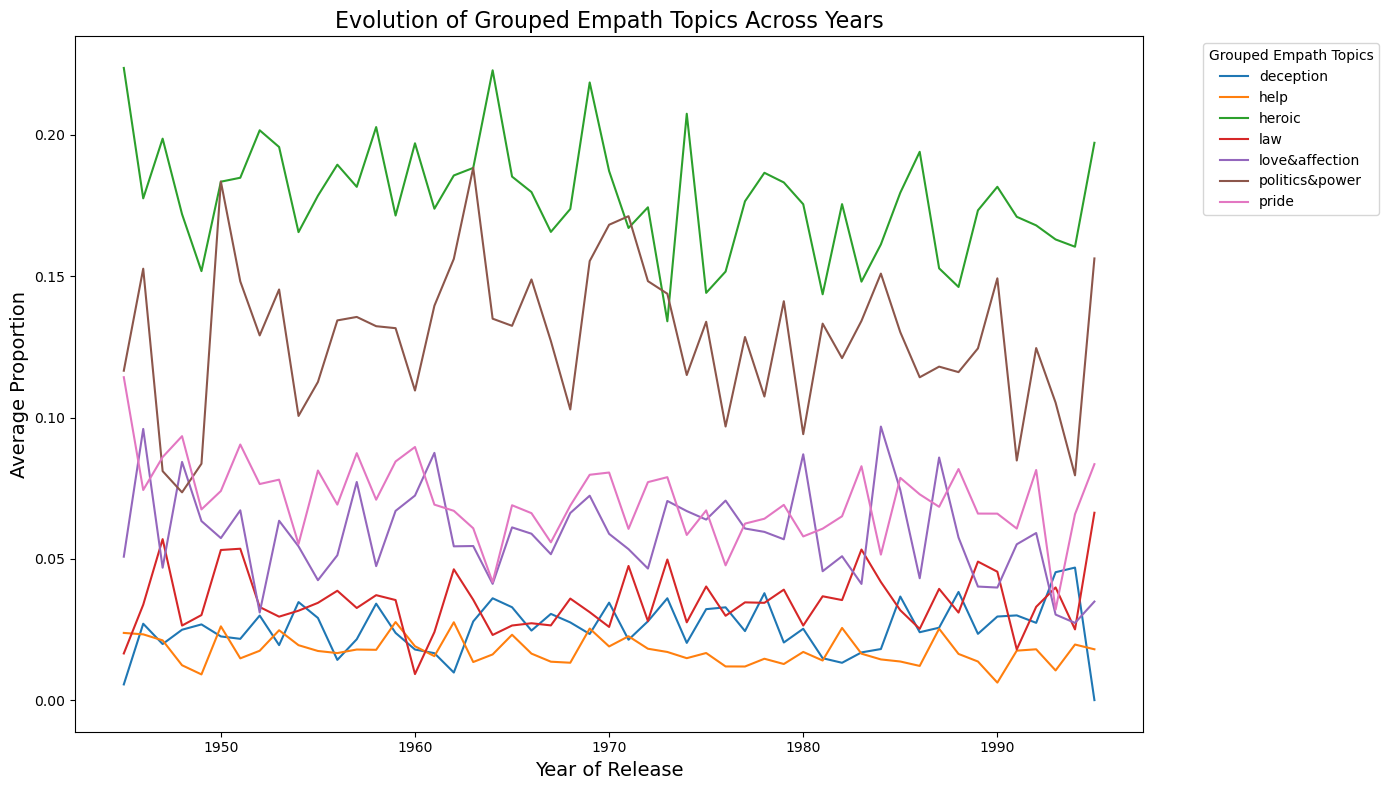

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

character_df = character_df.dropna(subset=['empath_analysis'])

# Define groups of similar topics
topic_groups = {
    'love&affection': ['love', 'affection', 'family', 'friends'],
    'politics&power': ['politics', 'leader', 'military', 'power'],
}

# Map each original topic to a new group
def map_topic_to_group(topic):
    for group, topics in topic_groups.items():
        if topic in topics:
            return group
    return topic  # If no group is found, return the topic itself

# Extract unique topics across all rows in the 'empath_analysis' column
empath_topics = set()
for entry in character_df['empath_analysis']:
    empath_topics.update(entry.keys())

# Create a new DataFrame to track topic proportions across years
topic_years = {topic: [] for topic in empath_topics}
topic_years['year'] = []

for year in sorted(character_df['year_release_date'].dropna().unique()):
    year_data = character_df[character_df['year_release_date'] == year]['empath_analysis']
    aggregated = {topic: 0 for topic in empath_topics}
    count = len(year_data)
    for entry in year_data:
        for topic, value in entry.items():
            aggregated[topic] += value
    if count > 0:
        for topic in aggregated:
            aggregated[topic] /= count
    for topic, value in aggregated.items():
        topic_years[topic].append(value)
    topic_years['year'].append(year)

topic_years_df = pd.DataFrame(topic_years)

# Melt the DataFrame for easier plotting
melted = topic_years_df.melt(id_vars=['year'], var_name='topic', value_name='proportion')

# Apply the grouping to the topics
melted['grouped_topic'] = melted['topic'].apply(map_topic_to_group)
grouped_melted = melted.groupby(['year', 'grouped_topic'], as_index=False).agg({'proportion': 'sum'})

# Plot the evolution of grouped empath topics over the years
plt.figure(figsize=(14, 8))
sns.lineplot(data=grouped_melted, x='year', y='proportion', hue='grouped_topic')
plt.title('Evolution of Grouped Empath Topics Across Years', fontsize=16)
plt.xlabel('Year of Release', fontsize=14)
plt.ylabel('Average Proportion', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Grouped Empath Topics')
plt.tight_layout()
plt.show()

In [79]:
import plotly.graph_objects as go

fig = go.Figure()

unique_years = sorted(melted['year'].unique())

# fix the y-axis 
max_y = melted['proportion'].max()

for year in unique_years:

    year_data = melted[melted['year'] == year]
    grouped_data = year_data.groupby('grouped_topic', as_index=False).agg({'proportion': 'sum'})
    
    fig.add_trace(go.Bar(
        x=grouped_data['grouped_topic'],
        y=grouped_data['proportion'],
        name=f"Year {year}",
        visible=(year == unique_years[0])  # Only show the first year's data initially
    ))

# Define steps for the slider
steps = []
for i, year in enumerate(unique_years):
    step = dict(
        method="update",
        args=[
            {"visible": [j == i for j in range(len(unique_years))]},  # Toggle visibility for the selected year
            {"title": f"Empath Topic Proportions for Year: {year}"}
        ],
        label=str(year)
    )
    steps.append(step)

# Add the slider to the layout
fig.update_layout(
    sliders=[{
        "active": 0,
        "currentvalue": {"prefix": "Year: "},
        "pad": {"t": 50},
        "steps": steps
    }],
    title="Dynamic Histogram of Grouped Empath Topics by Year",
    xaxis_title="Empath Topics",
    yaxis_title="Proportion",
    yaxis=dict(range=[0, max_y]),  # Set the fixed y-axis range
    legend_title="Year",
    barmode="group"  # This ensures bars are grouped by topics
)

# Show the plot
fig.show()
